C:\Users\Shafiya mariyam\AppData\Local\Temp\ipykernel_20476\257997462.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fairness_scores = df_test.groupby("Country").apply(


✅ Accuracy: 0.5200
✅ Precision: 0.5289
✅ Recall: 0.5539
✅ F1 Score: 0.5411
✅ Scalability (Inference Time in sec): 0.0020
✅ Reliability (Avg Score over 10 runs): 0.5024
✅ Fairness (Avg Accuracy across Countries): 0.4921


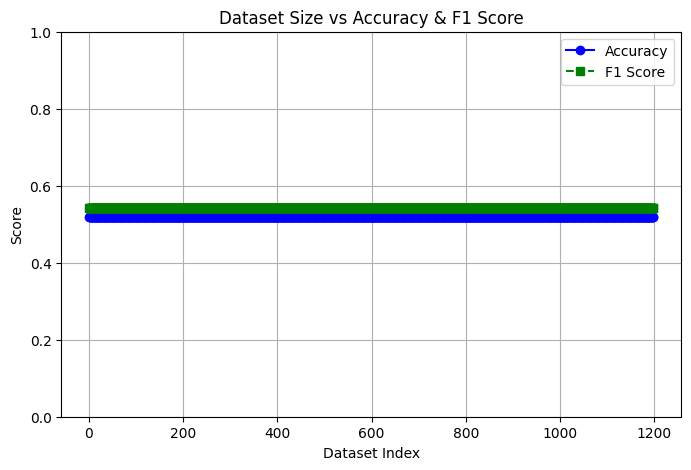

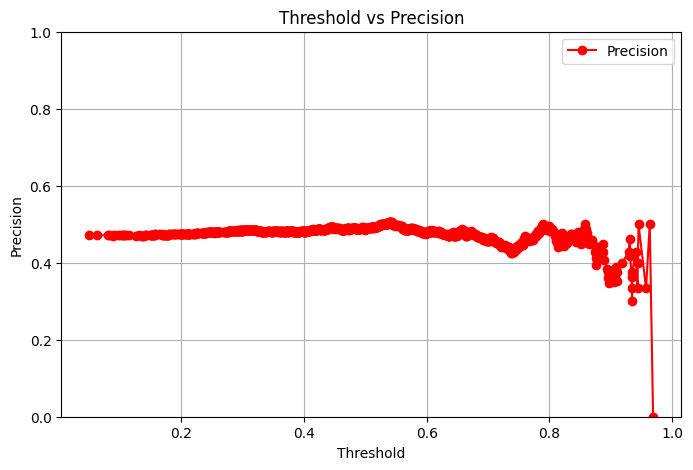

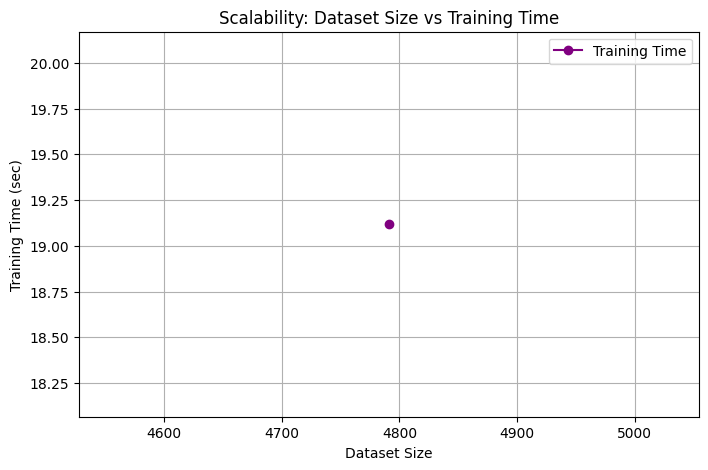

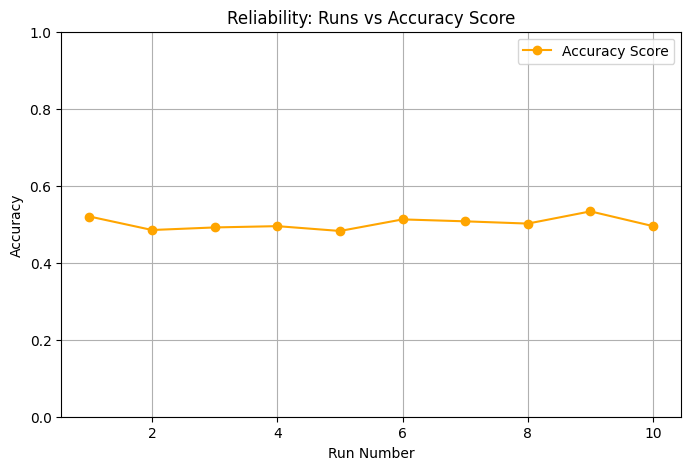

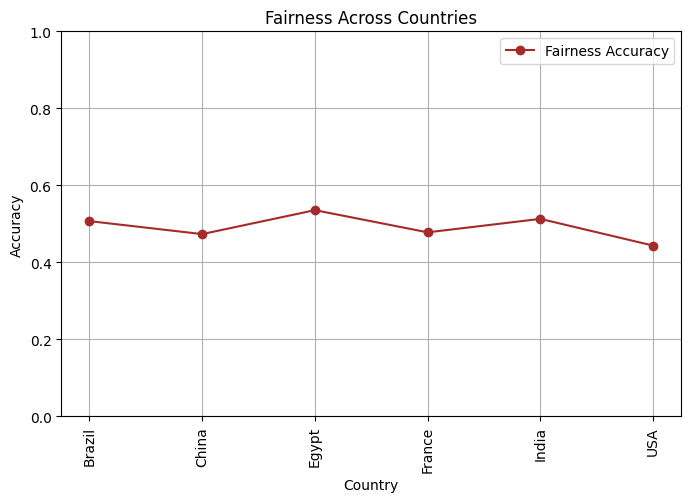

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

# 🔹 Step 1: Load Dataset
df = pd.read_csv(r"C:\Users\Shafiya mariyam\OneDrive\Documents\tourism_dataset.csv")  # Update path

# 🔹 Step 2: Convert target variable ("Yes"/"No") → (1/0)
df["Accommodation_Available"] = df["Accommodation_Available"].map({"Yes": 1, "No": 0}).astype(int)

# 🔹 Step 3: Convert categorical columns into numerical (One-Hot Encoding)
df = pd.get_dummies(df, columns=["Location", "Country", "Category"], drop_first=True)

# 🔹 Step 4: Define Features (X) and Target (y)
X = df.drop(columns=["Accommodation_Available"])
y = df["Accommodation_Available"]

# 🔹 Step 5: Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Step 6: Train Model with XGBoost
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric=["logloss"])

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time  # Training Time for Scalability Analysis

# 🔹 Step 7: Make Predictions
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for Threshold Analysis

# 🔹 Step 8: Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 🔹 Step 9: Compute Scalability (Inference Time)
start_time = time.time()
_ = model.predict(X_test)
inference_time = (time.time() - start_time) / len(X_test)  # Time per instance

# 🔹 Step 10: Compute Reliability (Avg Score Over 10 Runs)
reliability_scores = []
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    reliability_scores.append(accuracy_score(y_test, y_pred))

reliability = np.mean(reliability_scores)

# 🔹 Step 11: Compute Fairness (Accuracy Across Countries)
df_test = X_test.copy()
df_test["Actual"] = y_test.values
df_test["Predicted"] = y_pred

# Extract country names from one-hot encoded columns
country_cols = [col for col in df_test.columns if col.startswith("Country_")]
df_test["Country"] = df_test[country_cols].idxmax(axis=1).str.replace("Country_", "")

fairness_scores = df_test.groupby("Country").apply(
    lambda g: accuracy_score(g["Actual"], g["Predicted"])
).reset_index(name="Accuracy")
fairness_avg = fairness_scores["Accuracy"].mean()

# 🔹 Step 12: Print Metrics
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Scalability (Inference Time in sec): {inference_time:.4f}")
print(f"✅ Reliability (Avg Score over 10 runs): {reliability:.4f}")
print(f"✅ Fairness (Avg Accuracy across Countries): {fairness_avg:.4f}")

# 🔹 Step 13: Plot Graphs

# 1️⃣ Dataset Size vs Accuracy & F1 Score
dataset_indices = np.arange(1, len(y_test) + 1)
accuracy_values = [accuracy] * len(dataset_indices)
f1_values = [f1] * len(dataset_indices)

plt.figure(figsize=(8, 5))
plt.plot(dataset_indices, accuracy_values, marker="o", linestyle="-", color="b", label="Accuracy")
plt.plot(dataset_indices, f1_values, marker="s", linestyle="--", color="g", label="F1 Score")
plt.xlabel("Dataset Index")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Dataset Size vs Accuracy & F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# 2️⃣ Precision vs Threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], marker="o", linestyle="-", color="r", label="Precision")
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.title("Threshold vs Precision")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ Scalability (Dataset Size vs Training Time)
plt.figure(figsize=(8, 5))
plt.plot([len(X_train)], [training_time], marker="o", linestyle="-", color="purple", label="Training Time")
plt.xlabel("Dataset Size")
plt.ylabel("Training Time (sec)")
plt.title("Scalability: Dataset Size vs Training Time")
plt.legend()
plt.grid(True)
plt.show()

# 4️⃣ Reliability (Runs vs Accuracy Score)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), reliability_scores, marker="o", linestyle="-", color="orange", label="Accuracy Score")
plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Reliability: Runs vs Accuracy Score")
plt.legend()
plt.grid(True)
plt.show()

# 5️⃣ Fairness (Accuracy Across Countries)
plt.figure(figsize=(8, 5))
plt.plot(fairness_scores["Country"], fairness_scores["Accuracy"], marker="o", linestyle="-", color="brown", label="Fairness Accuracy")
plt.xlabel("Country")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Fairness Across Countries")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


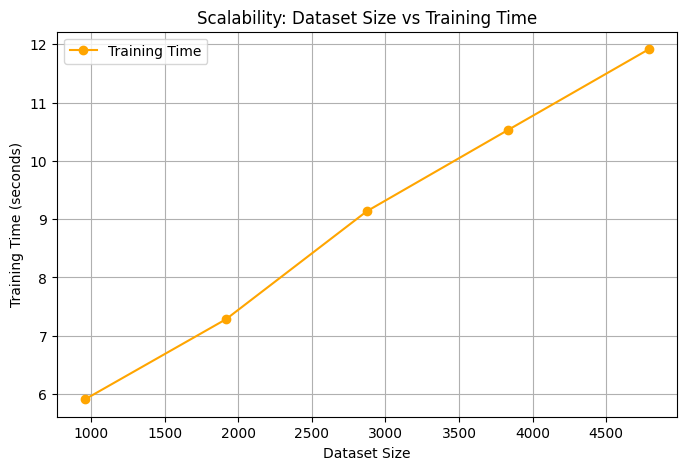

In [7]:
import time

# Different dataset sizes to test
sample_sizes = [int(len(X_train) * r) for r in [0.2, 0.4, 0.6, 0.8, 1.0]]
train_times = []

for size in sample_sizes:
    X_sample = X_train[:size]
    y_sample = y_train[:size]
    
    start_time = time.time()
    model.fit(X_sample, y_sample)
    end_time = time.time()
    
    train_times.append(end_time - start_time)

# Plot Scalability: Dataset Size vs Training Time
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, train_times, marker="o", linestyle="-", color="orange", label="Training Time")
plt.xlabel("Dataset Size")
plt.ylabel("Training Time (seconds)")
plt.title("Scalability: Dataset Size vs Training Time")
plt.legend()
plt.grid(True)
plt.show()
